# Normal-tangential coordinates

Author: Jukka Aho

**Abstract**: Use of normal tangential coordinate system

In [1]:
using JuliaFEM.Core: Quad4, Seg2, Seg3, PlaneStressLinearElasticityProblem, DirichletProblem, update!, DirectSolver
typealias Node Vector{Float64}

Array{Float64,1}

In [2]:
using Gadfly
set_default_plot_size(10cm, 10cm)

Element normal definition in 2d

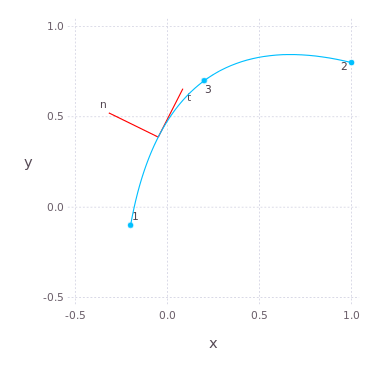

In [3]:
el = Seg3([1, 2, 3])
el["geometry"] = Node[[-0.2, -0.1], [1.0, 0.8], [0.2, 0.7]]
x = Float64[]
y = Float64[]
for xi in linspace(-1, 1)
    X = el("geometry", [xi], 0.0)
    push!(x, X[1])
    push!(y, X[2])
end
l1 = layer(x=x, y=y, Geom.line)

X1 = el("geometry", [-1.0], 0.0)
X2 = el("geometry", [1.0], 0.0)
X3 = el("geometry", [0.0], 0.0)
l2 = layer(x=[X1[1],X2[1],X3[1]], y=[X1[2],X2[2],X3[2]], label=["1","2","3"],
           Geom.point, Geom.label(;hide_overlaps=false))

xi = [-0.5]
X = el("geometry", xi, 0.0)
J = JuliaFEM.Core.get_jacobian(el, xi, 0.0)
t = vec(J)/norm(J)
n = [cos(pi/2) -sin(pi/2); sin(pi/2) cos(pi/2)]*t
a = 0.3
l3 = layer(x=[X[1], X[1]+a*t[1]], y=[X[2], X[2]+a*t[2]], label=["","t"],
           Geom.label(;hide_overlaps=false), Geom.line, Theme(default_color=colorant"red"))
l4 = layer(x=[X[1], X[1]+a*n[1]], y=[X[2], X[2]+a*n[2]], label=["","n"],
           Geom.label(;hide_overlaps=false), Geom.line, Theme(default_color=colorant"red"))

p = plot(l1, l2, l3, l4, Coord.Cartesian(xmin=-0.5, ymin=-0.5, xmax=1.0, ymax=1.0))

## Model defined in cartesian coordinates

Model defined using cartesian coordinates. In general set individual components of vector values using index number, 1=x, 2=y, 3=z.

In [4]:
geometry = Dict{Int64, Node}(
    1 => [0.0, 0.0],
    2 => [1.0, 0.0],
    3 => [1.0, 1.0],
    4 => [0.0, 1.0])
el1 = Quad4([1, 2, 3, 4])
el2 = Seg2([3, 4]) # load
el3 = Seg2([1, 2]) # symmetry 2
el4 = Seg2([4, 1]) # symmetry 1
update!([el1, el2, el3, el4], "geometry", geometry)
el1["youngs modulus"] = 900.0
el1["poissons ratio"] = 0.25
el2["displacement traction force 2"] = -100.0
el3["displacement 2"] = 0.0
el4["displacement 1"] = 0.0
problem = PlaneStressLinearElasticityProblem("block")
boundary = DirichletProblem("dirichlet boundary conditions", "displacement", 2)
push!(problem, el1, el2)
push!(boundary, el3, el4)
solver = DirectSolver("simple 2d block")
push!(solver, problem)
push!(solver, boundary)
solver.method = :UMFPACK
solver.nonlinear_problem = false
call(solver, 0.0)

INFO: Starting solver simple 2d block
INFO: # of field problems: 1
INFO: # of boundary problems: 1
INFO: Starting iteration 1
INFO: Assembling field problems...
INFO: Assembling body 1: block
INFO: dim = 8
INFO: Assembling boundary problems...
INFO: Assembling boundary 1: dirichlet boundary conditions
INFO: Solving system
INFO: UMFPACK: solved in 0.20885300636291504 seconds. norm = 0.16197088596792505


(1,true)

INFO: timing info for iteration:
INFO: boundary assembly       : 0.11499595642089844
INFO: field assembly          : 1.344099998474121
INFO: dump matrices to disk   : 1.1920928955078125e-6
INFO: solve problem           : 0.38971495628356934
INFO: update element data     : 0.031152963638305664
INFO: non-linear iteration    : 1.879986047744751
INFO: solver finished in 2.0280649662017822 seconds.


In [5]:
using JuliaFEM.Test
@test isapprox(el1("displacement", [1.0, 1.0], 0.0), [1/36, -1/9])

Test Passed
  Expression: isapprox(el1("displacement",[1.0,1.0],0.0),[1 / 36,-1 / 9])

In [6]:
norm(el1("displacement", [1.0, 1.0], 0.0))

0.11453071182271282

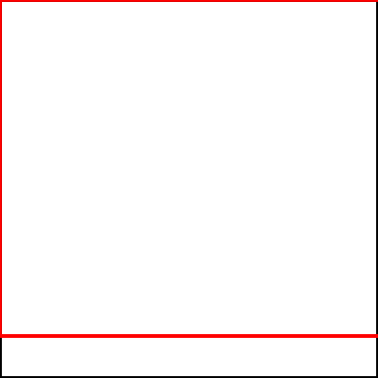

In [15]:
using Compose

X = el1("geometry")
u = el1("displacement", 0.0)
x = X+u

root = context(0, 0, 1, 1)
p1 = polygon([tuple(X[i][1], X[i][2]) for i=1:4])
p2 = polygon([tuple(x[i][1], x[i][2]) for i=1:4])
undeformed = compose(root, p1, linewidth(1mm), fill(nothing), stroke("black"))
deformed = compose(root, p2, linewidth(1mm), fill(nothing), stroke("red"))
compose(undeformed, deformed)

## Using normal tangential coordinates

Sometimes it's more convenient to set boundary conditions using normal-tangential coordinates.

In [58]:
rot(ϕ) = [cos(ϕ) -sin(ϕ); sin(ϕ) cos(ϕ)]

rot (generic function with 1 method)

In [84]:
using JuliaFEM.Core: Quad4, Seg2, Seg3, PlaneStressLinearElasticityProblem, DirichletProblem, update!, DirectSolver
typealias Node Vector{Float64}
using JuliaFEM.Core: calculate_normal_tangential_coordinates!

# 2d rotation matrix
#phi = pi/10
phi = 0.0
rmat(phi) = [cos(phi) -sin(phi); sin(phi) cos(phi)]

geometry = Dict{Int64, Node}(
    1 => rmat(phi)*[0.0, 0.0],
    2 => rmat(phi)*[1.0, 0.0],
    3 => rmat(phi)*[1.0, 1.0],
    4 => rmat(phi)*[0.0, 1.0])
el1 = Quad4([1, 2, 3, 4])
el2 = Seg2([3, 4]) # load
el3 = Seg2([1, 2]) # symmetry 2
el4 = Seg2([4, 1]) # symmetry 1
update!([el1, el2, el3, el4], "geometry", geometry)
calculate_normal_tangential_coordinates!([el2, el3, el4], 0.0)

el1["youngs modulus"] = 900.0
el1["poissons ratio"] = 0.25
# traction force in local coordinates
el2["local displacement traction force 1"] = 100.0
# support sides in local coordinates
el3["local displacement 1"] = 0.0
el4["local displacement 2"] = 0.0
for el in [el3, el4]
    el["displacement near coord (0.0,0.0)"] = 0.0
end
problem = PlaneStressLinearElasticityProblem("block")
boundary = DirichletProblem("dirichlet boundary conditions", "displacement", 2)
push!(problem, el1, el2)
push!(boundary, el3, el4)
solver = DirectSolver("rotated 2d block")
push!(solver, problem)
push!(solver, boundary)
solver.method = :UMFPACK
solver.nonlinear_problem = false
#call(solver, 0.0)

false

In [85]:
K = sparse(JuliaFEM.Core.assemble(problem, 0.0).stiffness_matrix)
f = sparse(JuliaFEM.Core.assemble(problem, 0.0).force_vector)

8x1 sparse matrix with 2 Float64 entries:
	[6, 1]  =  -50.0
	[8, 1]  =  -50.0

In [21]:
using JuliaFEM.Core: SparseMatrixCOO

"""
For general problem type
Au + C₁'λ = f
C₂u + Dλ  = g
"""
type BoundaryAssembly
    C1 :: SparseMatrixCOO
    C2 :: SparseMatrixCOO
    D :: SparseMatrixCOO
end

In [27]:
function BoundaryAssembly()
    return BoundaryAssembly(SparseMatrixCOO(), SparseMatrixCOO(), SparseMatrixCOO())
end

BoundaryAssembly

In [86]:
using JuliaFEM.Core: get_gdofs, get_integration_points, get_jacobian, add!, get_connectivity

function do_boundary()
    assembly = BoundaryAssembly()
    field_dim = 2
    time = 0.0
    for element in [el3, el4]
        gdofs = get_gdofs(element, field_dim)
        for ip in get_integration_points(element, Val{2})
            w = ip.weight
            J = get_jacobian(element, ip, time)
            N = element(ip, time)
            N_bo = [1/2*(1-3*ip.xi[1]) 1/2*(1+3*ip.xi[1])]
            #C1 = w*N_bo'*N*norm(J)
            De = eye(2)*norm(J)
            info("De = $De")
            # add to C1
            for i=1:field_dim
                ldofs = gdofs[i:field_dim:end]
                add!(assembly.C1, ldofs, ldofs, De)
            end
            # add to C2
            nt = element("normal-tangential coordinates", ip, time)
            nt = transpose(nt)
            normal = nt[1,:]
            tangent = nt[2,:]
            for nid in get_connectivity(element)
                ndofs = [2*(nid-1)+1, 2*(nid-1)+2]
                add!(assembly.C2, [2*(nid-1)+1], ndofs, normal)
                add!(assembly.D, [2*(nid-1)+2], ndofs, tangent)
            end
        end
    end
    return assembly
end

ntass = do_boundary()
ENV["COLUMNS"] = 300
dump(round(full(ntass.C1), 2))
dump(round(full(ntass.C2), 2))
dump(round(full(ntass.D), 2))

INFO: De = [0.5 0.0
 0.0 0.5]
INFO: De = [0.5 0.0
 0.0 0.5]


Array(Float64,(8,8)) 8x8 Array{Float64,2}

INFO: De = [0.5 0.0
 0.0 0.5]
INFO: De = [0.5 0.0
 0.0 0.5]


:
 2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
Array(Float64,(7,8)) 7x8 Array{Float64,2}:
 2.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0
Array(Float64,(8,8)) 8x8 Array{Float64,2}:
 0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0
 2.0  -2.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0   0.0  2.0  0.0  0.0  0.0  0.0   0.0
 0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0   0.0  0.0  0

In [98]:
g = spzeros(8, 1)
A = [K B'; C D]
b = [f; g]

info("size of A = $(size(A))")
ENV["COLUMNS"] = 300

dim = size(A, 1)
info("total dim = $dim")

nz1 = sort(unique(rowvals(A)))
nz2 = sort(unique(rowvals(A')))
A = A[nz1, nz2]
b = b[nz1]
u = zeros(dim)
T = full(A)
T[abs(T) .< 1.0e-9] = 0
info("solving")
sol = T \ full(b)
info("solved")

u[nz1] = sol
u[abs(u).<1.0e-9] = 0.0
u = reshape(full(u), 2, round(Int, length(u)/2))
full(u)

INFO: size of A = (16,16)
INFO: total dim = 16


2x8 Array{Float64,2}:
 0.0  0.0277778   0.0277778   0.0         0.0    0.0  0.0  0.0
 0.0  0.0        -0.111111   -0.111111  -25.0  -25.0  0.0  0.0

INFO: solving
INFO: solved


In [87]:
u[:,3]

2-element Array{Float64,1}:
  0.0277778
 -0.111111 

In [88]:
@test isapprox(norm(u[:,3]), 0.11453071182271282)

Test Passed
  Expression: isapprox(norm(u[:,3]),0.11453071182271282)

In [89]:
round(Int, T)

16x16 Array{Int64,2}:
  440   150  -260   -30  -220  -150    40    30  2  0  0  0   0  0  0  0
  150   440    30    40  -150  -220   -30  -260  0  2  0  0   0  0  0  0
 -260    30   440  -150    40   -30  -220   150  0  0  2  0   0  0  0  0
  -30    40  -150   440    30  -260   150  -220  0  0  0  2   0  0  0  0
 -220  -150    40    30   440   150  -260   -30  0  0  0  0   2  0  0  0
 -150  -220   -30  -260   150   440    30    40  0  0  0  0   0  2  0  0
   40   -30  -220   150  -260    30   440  -150  0  0  0  0   0  0  2  0
   30  -260   150  -220   -30    40  -150   440  0  0  0  0   0  0  0  2
    0     1     0     0     0     0     0     0  0  0  0  0   0  0  0  0
    1     0     0     0     0     0     0     0  0  0  0  0   0  0  0  0
    0     0     0     1     0     0     0     0  0  0  0  0   0  0  0  0
    0     0     0     0     0     0     0     0  0  0  1  0   0  0  0  0
    0     0     0     0     0     0     0     0  0  0  0  0  -1  0  0  0
    0     0     0     0     0

In [119]:
C1 = sparse(ntass.C1, 8, 8)
C2 = sparse(ntass.C2, 8, 8)
D  = sparse(ntass.D, 8, 8)
C2[1,:] = 0
D[2,:] = 0
C2[1,1] = 1
C2[2,2] = 1
#C2[2,:] = D[2,:]
#D[2,:] = 0
A = [K C1'; C2 D]
#A[9,:] = 0
#A[9, 1] = 1
#A[10,:] = 0
#A[10, 1] = 2
#A[10, 2] = -2
full(A)

16x16 Array{Float64,2}:
  440.0   150.0  -260.0   -30.0  -220.0  -150.0    40.0    30.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0
  150.0   440.0    30.0    40.0  -150.0  -220.0   -30.0  -260.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0   0.0
 -260.0    30.0   440.0  -150.0    40.0   -30.0  -220.0   150.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   0.0
  -30.0    40.0  -150.0   440.0    30.0  -260.0   150.0  -220.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   0.0
 -220.0  -150.0    40.0    30.0   440.0   150.0  -260.0   -30.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0
 -150.0  -220.0   -30.0  -260.0   150.0   440.0    30.0    40.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0
   40.0   -30.0  -220.0   150.0  -260.0    30.0   440.0  -150.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   0.0
   30.0  -260.0   150.0  -220.0   -30.0    40.0  -150.0   440.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   1.0
    1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0
    0.0     1.0     0.0     0.0

In [120]:
b = [f; spzeros(8, 1)]
nz1 = sort(unique(rowvals(A)))
nz2 = sort(unique(rowvals(A')))
sol = zeros(length(b))
sol[nz1] = A[nz1, nz2] \ full(b)[nz1]
sol[abs(sol) .< 1.0e-9] = 0
sol = reshape(sol, 2, 8)

2x8 Array{Float64,2}:
 0.0  0.0277778   0.0277778   0.0         0.0    0.0  0.0  0.0
 0.0  0.0        -0.111111   -0.111111  -25.0  -50.0  0.0  0.0

In [83]:
@test isapprox(norm(sol[:,3]), 0.11453071182271282)

Test Passed
  Expression: isapprox(norm(sol[:,3]),0.11453071182271282)

In [13]:
u_tip = el1("displacement", [1.0, 1.0], 0.0)
info("displacement on tip: $u_tip, magnitude = $(norm(u_tip))")

LoadError: LoadError: KeyError: displacement not found
while loading In[13], in expression starting on line 1

In [14]:
using JuliaFEM.Test
@test isapprox(norm(u_tip), norm([1/36, -1/9]))

Error During Test
  Test threw an exception of type UndefVarError
  Expression: isapprox(

LoadError: LoadError: There was an error during testing
while loading In[14], in expression starting on line 2

norm(u_tip),norm([1 / 36,-1 / 9]))
  UndefVarError: u_tip not defined
   in anonymous at /home/jukka/.julia/v0.4/BaseTestNext/src/BaseTestNext.jl:165
   in do_test at /home/jukka/.julia/v0.4/BaseTestNext/src/BaseTestNext.jl:181
   in include_string at loading.jl:266
   in execute_request_0x535c5df2 at /home/jukka/.julia/v0.4/IJulia/src/execute_request.jl:177
   in eventloop at /home/jukka/.julia/v0.4/IJulia/src/IJulia.jl:141
   in anonymous at task.jl:447


In [1]:
using JuliaFEM.Core: Seg2, Element, update!
using JuliaFEM.Core: calculate_normal_tangential_coordinates!
typealias Node Vector{Float64}

nodes = Dict{Int, Node}(
1 => [0.0, 0.1],
2 => [1.0, 0.3],
3 => [2.0, -0.1],
4 => [3.0, 0.6],
5 => [4.0, 0.3])

s1 = Seg2([1, 2])
s2 = Seg2([2, 3])
s3 = Seg2([3, 4])
s4 = Seg2([4, 5])
elems = Element[s1, s2, s3, s4]
update!(elems, "geometry", nodes)
calculate_normal_tangential_coordinates!([s1, s2, s3, s4], 0.0)

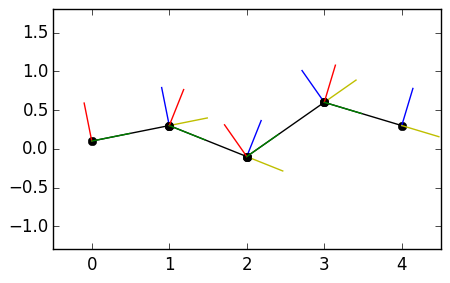

(-0.5,4.5)

In [2]:
using PyPlot
fig = figure(figsize=(5, 3))
for s in [s1, s2, s3, s4]
    X1 = s("geometry", [-1.0], 0.0)
    X2 = s("geometry", [ 1.0], 0.0)
    nt1 = s("normal-tangential coordinates", [-1.0], 0.0)
    nt2 = s("normal-tangential coordinates", [ 1.0], 0.0)
    plot([X1[1],X2[1]], [X1[2],X2[2]], "-ko")
    X1N1 = X1 + nt1[:,1]*0.5
    X1T1 = X1 + nt1[:,2]*0.5
    plot([X1[1],X1N1[1]], [X1[2],X1N1[2]], "-r")
    plot([X1[1],X1T1[1]], [X1[2],X1T1[2]], "-g")
    X2N2 = X2 + nt2[:,1]*0.5
    X2T2 = X2 + nt2[:,2]*0.5
    plot([X2[1],X2N2[1]], [X2[2],X2N2[2]], "-b")
    plot([X2[1],X2T2[1]], [X2[2],X2T2[2]], "-y")
end
axis("equal")
ylim(-0.5, 1.0)
xlim(-0.5, 4.5)

In [12]:
using JuliaFEM.Core: SparseMatrixCOO, Element, get_integration_points, get_jacobian, get_connectivity, add!

function calculate_normal_tangential_coordinates(elements::Vector{Element}, time::Real)
    P = SparseMatrixCOO()
    field_dim = 2
    time = 0.0
    for element in elements
        for ip in get_integration_points(element, Val{2})
            J = get_jacobian(element, ip, time)
            w = ip.weight*norm(J)
            nt = transpose(element("normal-tangential coordinates", ip, time))
            normal = nt[1,:]
            tangent = nt[2,:]
            for nid in get_connectivity(element)
                ndofs = [2*(nid-1)+1, 2*(nid-1)+2]
                add!(P, [2*(nid-1)+1], ndofs, normal)
                add!(P, [2*(nid-1)+2], ndofs, tangent)
            end
        end
    end
    P = sparse(P)
    for i=1:size(P,1)
        if sum(abs(P[i,:])) > 0.0
            P[i,:] = P[i,:] / norm(P[i,:])
        end
    end
    return P
end
P = calculate_normal_tangential_coordinates(Element[s1, s2, s3, s4], 0.0)
P = full(P)

10x10 Array{Float64,2}:
 -0.196116  0.980581  0.0         0.0        …  0.0       0.0        0.0     
  0.980581  0.196116  0.0         0.0           0.0       0.0        0.0     
  0.0       0.0       0.0914276   0.995812      0.0       0.0        0.0     
  0.0       0.0       0.995812   -0.0914276     0.0       0.0        0.0     
  0.0       0.0       0.0         0.0           0.0       0.0        0.0     
  0.0       0.0       0.0         0.0        …  0.0       0.0        0.0     
  0.0       0.0       0.0         0.0           0.987285  0.0        0.0     
  0.0       0.0       0.0         0.0           0.158957  0.0        0.0     
  0.0       0.0       0.0         0.0           0.0       0.287348   0.957826
  0.0       0.0       0.0         0.0           0.0       0.957826  -0.287348

i = 1, normal = [-0.19611613513818404,0.9805806756909202], tangent = [0.9805806756909202,0.19611613513818404], dot = 0

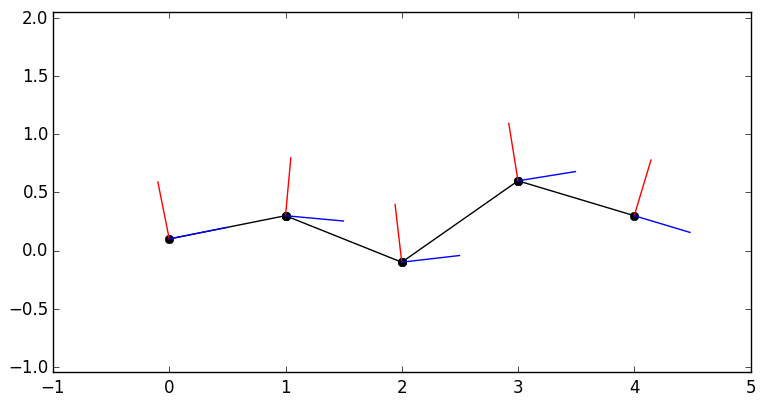

(-1.0,5.0,-0.2,1.2000000000000002)

.0
i = 2, normal = [0.09142755332923394,0.9958117304451831], tangent = [0.9958117304451831,-0.09142755332923394], dot = 0.0
i = 3, normal = [-0.11485575612958872,0.9933821798703159], tangent = [0.9933821798703159,0.11485575612958872], dot = 0.0
i = 4, normal = [-0.15895744828402364,0.9872854347325458], tangent = [0.9872854347325458,0.15895744828402364], dot = 0.0
i = 5, normal = [0.28734788556634544,0.9578262852211514], tangent = [0.9578262852211514,-0.28734788556634544], dot = 0.0


In [13]:
for s in [s1, s2, s3, s4]
    X1 = s("geometry", [-1.0], 0.0)
    X2 = s("geometry", [ 1.0], 0.0)
    plot([X1[1],X2[1]], [X1[2],X2[2]], "-ko")
end
for i=1:5
    s = 2*(i-1)+1
    e = s + 1
    normal = vec(P[2*(i-1)+1, s:e])
    tangent = vec(P[2*(i-1)+2, s:e])
    println("i = $i, normal = $normal, tangent = $tangent, dot = ", dot(normal, tangent))
    plot([nodes[i][1], nodes[i][1]+normal[1]*0.5], [nodes[i][2], nodes[i][2]+normal[2]*0.5], "-r")
    plot([nodes[i][1], nodes[i][1]+tangent[1]*0.5], [nodes[i][2], nodes[i][2]+tangent[2]*0.5], "-b")
end
ylim(-0.5, 1.0)
xlim(-0.5, 4.5)
axis("equal")